In [10]:
from psrpop import *
import numpy as np
import matplotlib.pyplot as plt
from oompy import Units as u
import pygedm

In [16]:
from scipy.interpolate import RegularGridInterpolator

def MW_Radial(R, R1, RSun, a, b):
    return ((R + R1) / (RSun + R1)) ** a * np.exp(-b * (R - RSun) / (RSun + R1))


def MW_Z(z, hc):
    return np.exp(-np.abs(z) / hc)


PARAMETERS = {
    "init_model": {
        "radial_distribution": Distribution(
            xmin=0, xmax=20, pdf=MW_Radial, R1=0.55, RSun=8.5, a=1.64, b=4.0
        ),
        "z_distribution": Distribution(xmin=-5, xmax=5, pdf=MW_Z, hc=0.18),
        "Bsurf": {
            "mean_log10": 12.65,
            "std_log10": 0.55,
        },
        "P": {
            "mean": 0.3,
            "std": 0.15,
            "threshold": 0.85e-3,
        },
    },
    "detectability": {
        "h_em": 3e5 * u.m,
        "tau_scat_coeff": 1.0,
        "tau_DM_coeff": 1.0,
        "tau_samp_coeff": 1.0,
    },
    "dummy": {},
}
dmgrid = np.load("dm_grid.npz")

pulsars = Simulate_Evolution(
    PARAMETERS,
    birth_rate=2 / 100,
    total_time=1e3,
    nbraking=2.5,
    beta=0.05,
    dm_interpolator=RegularGridInterpolator(
        (dmgrid['l'], dmgrid['angl'], dmgrid['dist']), dmgrid['dm_grid'], method='linear'
    )
)

In [12]:
pulsars.DMs

KeyboardInterrupt: 

In [17]:
pulsars.int_DMs

array([ 598.00198459,  178.75376064,  432.02008543,  583.91105928,
        567.51225755,  604.95150288,  666.63293722,  447.15822957,
        234.53796216,  578.6966765 ,  518.12554264,  468.81203228,
        483.08293016,  928.18538533,  683.25204023,  586.55990528,
        560.49388279,  252.40251843,  497.75186048, 1093.60493546])

In [23]:
catalog = Read_Catalogue()
print(list(catalog.keys()))  # inspect available columns
print({k: catalog[k][:3] for k in catalog.keys()})  # preview first 3 rows

['#', 'NAME', 'P0', 'P1', 'W50', 'W10', 'S400', 'S1400', 'S2000', 'DIST', 'DIST_DM', 'ZZ', 'XX', 'YY']
{'#': array(['1', '2', '3'], dtype='<U21'), 'NAME': array(['J0002+6216', 'J0006+1834', 'J0007+7303'], dtype='<U21'), 'P0': array(['0.1153635682680', '0.69374767047', '0.3158731909'], dtype='<U21'), 'P1': array(['5.96703E-15', '2.097E-15', '3.6039E-13'], dtype='<U21'), 'W50': array(['*', '61.3', '*'], dtype='<U21'), 'W10': array(['*', '112.1', '*'], dtype='<U21'), 'S400': array(['*', '0.2', '*'], dtype='<U21'), 'S1400': array(['0.022', '*', '*'], dtype='<U21'), 'S2000': array(['*', '*', '*'], dtype='<U21'), 'DIST': array(['6.357', '0.860', '1.400'], dtype='<U21'), 'DIST_DM': array(['6.357', '0.860', '*'], dtype='<U21'), 'ZZ': array(['-0.008', '-0.586', '0.254'], dtype='<U21'), 'XX': array(['5.648', '0.598', '1.196'], dtype='<U21'), 'YY': array(['11.418', '8.696', '9.181'], dtype='<U21')}


In [19]:
catalog

{'#': array(['1', '2', '3', ..., '4349', '4350', '4351'],
       shape=(4351,), dtype='<U21'),
 'NAME': array(['J0002+6216', 'J0006+1834', 'J0007+7303', ..., 'J2355+04',
        'J2355+1523', 'J2355+2246'], shape=(4351,), dtype='<U21'),
 'P0': array(['0.1153635682680', '0.69374767047', '0.3158731909', ..., '0.958',
        '1.09439626470', '1.8409859072'], shape=(4351,), dtype='<U21'),
 'P1': array(['5.96703E-15', '2.097E-15', '3.6039E-13', ..., '*', '4.2E-16',
        '3.78E-15'], shape=(4351,), dtype='<U21'),
 'W50': array(['*', '61.3', '*', ..., '*', '*', '47.6'],
       shape=(4351,), dtype='<U21'),
 'W10': array(['*', '112.1', '*', ..., '*', '*', '87.2'],
       shape=(4351,), dtype='<U21'),
 'S400': array(['*', '0.2', '*', ..., '*', '*', '0.9'], shape=(4351,), dtype='<U21'),
 'S1400': array(['0.022', '*', '*', ..., '*', '*', '*'], shape=(4351,), dtype='<U21'),
 'S2000': array(['*', '*', '*', ..., '*', '*', '*'], shape=(4351,), dtype='<U21'),
 'DIST': array(['6.357', '0.860', '1.4

In [24]:
mask = (
    (catalog["P0"] != "*")
    & (catalog["P1"] != "*")
    & (catalog["DIST_DM"] != "*")
    & (catalog["XX"] != "*")
    & (catalog["YY"] != "*")
    & (catalog["ZZ"] != "*")
)
catalog = {k: catalog[k][mask].astype(float) for k in ["P0", "P1", "DIST_DM", "XX", "YY", "ZZ"]}

mask = IsNormalPulsar(catalog["P0"], catalog["P1"])
catalog = {k: catalog[k][mask] for k in ["P0", "P1", "DIST_DM", "XX", "YY", "ZZ"]}

xx, yy, zz = catalog["XX"], catalog["YY"], catalog["ZZ"]
gal_l = np.arctan2(yy, xx) * 180 / np.pi
gal_b = np.arctan2(zz, np.sqrt(xx**2 + yy**2)) * 180 / np.pi
dist_kpc = catalog["DIST_DM"]

catalog["DM"] = np.array([
    pygedm.dist_to_dm(l, b, d * 1e3)[0].value
    for l, b, d in zip(gal_l, gal_b, dist_kpc)
])

/opt/anaconda3/envs/psr/lib/python3.11/site-packages/pygedm/pygedm.py:112: UserWarning: Distance too large, setting to 50 kpc.
  warnings.warn("Distance too large, setting to 50 kpc.", UserWarning)


In [28]:
catalog["DM"]

array([106.37406921,  13.5439539 ,  74.8034668 , ...,  36.36359787,
        40.88441086,  31.70462608], shape=(2107,))

In [25]:
detectable_pulsars = (
    pulsars
        .select(Detectable_Geometric, PARAMETERS)
        .select(Detectable_Radioflux, PARAMETERS)
        .select(lambda psr, _: IsNormalPulsar(psr.Ps, psr.Pdots), PARAMETERS)
)

number of observed psrs 264
number of synthetic psrs 0
number of all synthetic psrs 20


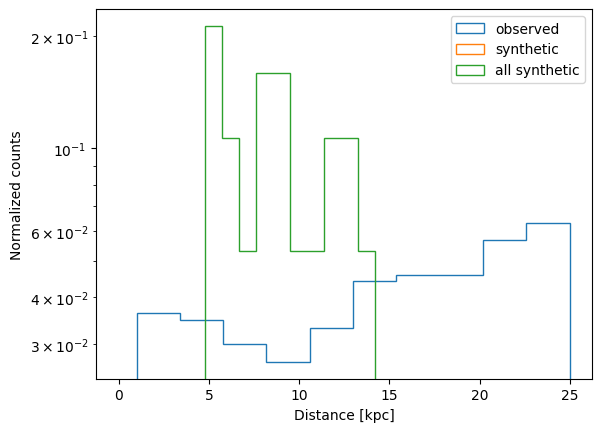

In [30]:
dist = catalog["DM"]
p0 = catalog["P0"]

observed_dist = dist[(dist < 25) & (p0 > 0.1)] #whats a good number to change the 25 to for DM
print("number of observed psrs", len(observed_dist))

synthetic_dist = detectable_pulsars.distances
print("number of synthetic psrs", len(synthetic_dist))

all_synthetic_dist = pulsars.distances
print("number of all synthetic psrs", len(all_synthetic_dist))

plt.hist(observed_dist, histtype="step", density=True, label="observed")
plt.hist(synthetic_dist, histtype="step", density=True, label="synthetic")
plt.hist(all_synthetic_dist, histtype="step", density=True, label="all synthetic")
plt.xlabel("Distance [kpc]")
plt.ylabel("Normalized counts")
plt.legend()
plt.yscale("log")